In [331]:
import numpy as np
import numba as nb
import time

In [332]:
b = 20
q = 1/10
w = 10
#defining all possibile starting point spaced by 0.2
x, y = np.meshgrid(np.arange(-3, 3, 0.25), np.arange(-3, 3, 0.25))
starting_points = np.array([[i,j] for i,j in zip(np.concatenate(x),np.concatenate(y))])

#function to be minimized
def f(x, y):
    return b*(1-np.exp( - (1/2) * w * (x**2 + y**2))) + (q/2) * ( - x**3 + y)**2

#derivative w.r.t x
def fx(x, y):
    return b * np.exp(-1/2 * w * (x**2 + y**2)) * w * x - 3 * q * x**2 *(-x**3 + y)

#derivative w.r.t y
def fy(x, y):
    return b * np.exp(-1/2 * w * (x**2 + y**2)) * w * y + q *(-x**3 + y)

#gradient
def grad_f(x,y):
    return [fx(x,y), fy(x,y)]
    

copio tutte le funzione che servono per plottare dal notebook  di Mehta

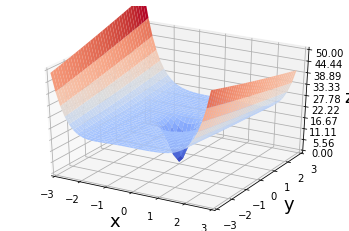

In [333]:
#Make plots of surfaces
x, y = np.meshgrid(np.arange(-3, 3, 0.15), np.arange(-3, 3, 0.15))

fig1,ax1=plot_surface(x,y,f(x,y))


plt.show()




In [334]:
#This writes a simple gradient descent and gradient descent+ momentum

#Mean-gradient based methods

def gd(grad, init, n_epochs=10000, eta=10**-4, noise_strength=0):
    #This is a simple optimizer
    param=init
    v=0;
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(param.size)
        v=eta*(np.array(grad(param[0], param[1]))+noise)
        param=param-v
    return param

def gd_with_mom(grad, init, n_epochs=5000, eta=10**-4, gamma=0.9,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        v=gamma*v+eta*(np.array(grad(params))+noise)
        params=params-v
        param_traj[j+1,]=params
    return param_traj

In [335]:
#first we find the best parameters for our gd algorithm

test = []
for noise in np.logspace(-4,-1,4):
    for eta in np.logspace(-4,-1,4):
        gd_1 = []
        for init1 in starting_points:
            gd_1.append(gd(grad_f,init1, n_epochs=1000, eta=eta, noise_strength = noise))
    
        test.append((np.array(gd_1)**2).sum())


/Users/mattiaceravolo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
/Users/mattiaceravolo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/mattiaceravolo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in double_scalars
/Users/mattiaceravolo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


In [336]:
np.array(test)

array([2577.72144175, 1833.23403792, 1037.04531044,           nan,
       2577.72151272, 1833.23467565, 1037.02157859,           nan,
       2577.7233585 , 1833.24407439, 1037.22868493,           nan,
       2577.69634674, 1833.21592799, 1038.96317334,           nan])